In [ ]:
!./data/eTaPR-1.12-py3-none-any.whl

In [1]:
! pip install statsmodels

You should consider upgrading via the '/Users/jinpark/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
from statsmodels.tsa.seasonal import STL

In [4]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr


In [5]:
TRAIN_DATASET = sorted([x for x in Path("data/HAI_2.0/training/").glob("*.csv")])
TRAIN_DATASET

[PosixPath('data/HAI_2.0/training/train1.csv'),
 PosixPath('data/HAI_2.0/training/train2.csv'),
 PosixPath('data/HAI_2.0/training/train3.csv')]

In [6]:
TEST_DATASET = sorted([x for x in Path("data/HAI_2.0/testing/").glob("*.csv")])
TEST_DATASET

[PosixPath('data/HAI_2.0/testing/test1.csv'),
 PosixPath('data/HAI_2.0/testing/test2.csv'),
 PosixPath('data/HAI_2.0/testing/test3.csv'),
 PosixPath('data/HAI_2.0/testing/test4.csv')]

In [7]:
VALIDATION_DATASET = sorted([x for x in Path("data/HAI_2.0/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('data/HAI_2.0/validation/validation.csv')]

In [8]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [55]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
5,2020-07-11 00:00:05,395.24640,12,10,52.79694,-1.8713,-1.88294,780.38776,28.02561,11512.0,...,829.60516,0.0,1.36810,8.86826,35.43700,12.01782,302.04718,296.83881,33.6555,6.0244
6,2020-07-11 00:00:06,395.34866,12,10,52.79694,-1.8651,-1.88294,783.65607,28.02301,11624.0,...,831.34473,0.0,1.35895,8.88958,35.43700,12.01782,301.52270,296.24207,33.6555,6.2372
7,2020-07-11 00:00:07,395.39975,12,10,52.79694,-1.7046,-1.88294,779.70721,28.02818,11736.0,...,821.34241,0.0,1.35971,8.91155,35.43700,12.01782,301.21527,295.68140,33.6555,6.4729
8,2020-07-11 00:00:08,395.34866,12,10,52.79694,-1.5038,-1.88294,779.65717,28.02385,11840.0,...,820.90759,0.0,1.35895,8.94309,35.43700,12.01782,300.72699,295.31976,33.6555,6.5049
9,2020-07-11 00:00:09,395.34866,12,10,52.79694,-1.3420,-1.87531,779.99420,28.02909,11936.0,...,821.77741,0.0,1.35895,8.93967,35.43700,12.01782,300.65466,294.88568,33.6555,6.3823


In [56]:
TRAIN_DF_RAW.columns

Index(['time', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09',
       'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19',
       'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29',
       'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39',
       'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49',
       'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59',
       'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69',
       'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

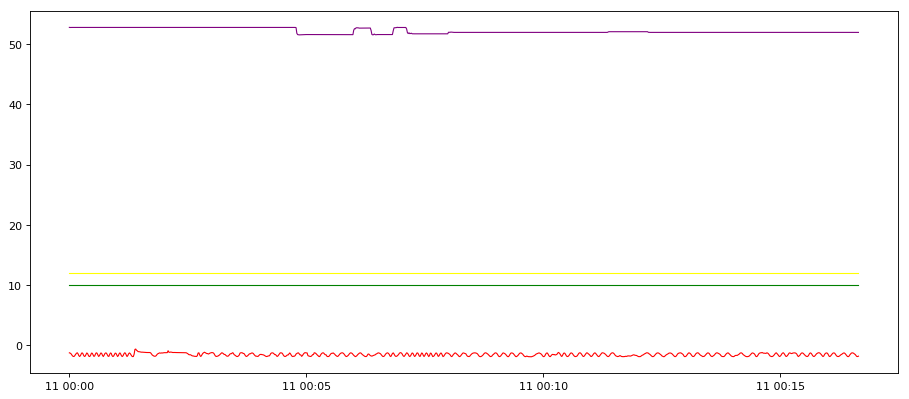

In [164]:
def plot_sp_normal():
    x = TRAIN_DF_RAW[['C01', 'C02', 'C03', 'C04', 'C05']].values
    fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    size = len(x)
    t = pd.to_datetime(TRAIN_DF_RAW['time'])
    t = t[:1000]
#     ax.plot(t, x[:1000,0], '-', color='blue', animated = True, linewidth=1)
    ax.plot(t, x[:1000,1], '-', color='yellow', animated = True, linewidth=1)
    ax.plot(t, x[:1000,2], '-', color='green', animated = True, linewidth=1)
    ax.plot(t, x[:1000,3], '-', color='purple', animated = True, linewidth=1)
    ax.plot(t, x[:1000,4], '-', color='red', animated = True, linewidth=1)
plot_sp_normal()

In [67]:
from datetime import datetime
period = TRAIN_DF_RAW['time'] > '2020-07-18 00:00:01'
TRAIN_DF_RAW[period]
TRAIN_DF_RAW['C01']

0         395.19528
1         395.14420
2         395.14420
3         395.19528
4         395.34866
5         395.24640
6         395.34866
7         395.39975
8         395.34866
9         395.34866
10        395.24640
11        395.29755
12        395.29755
13        395.29755
14        395.29755
15        395.24640
16        395.34866
17        395.55310
18        395.39975
19        395.29755
20        395.34866
21        395.45090
22        395.29755
23        395.29755
24        395.50201
25        395.65537
26        395.55310
27        395.45090
28        395.50201
29        395.45090
            ...    
478771    386.60764
478772    386.60764
478773    386.76102
478774    386.70990
478775    386.65875
478776    386.70990
478777    386.91437
478778    386.96549
478779    387.16992
478780    387.06772
478781    387.27219
478782    387.16992
478783    387.27219
478784    387.06772
478785    387.01657
478786    387.01657
478787    387.11883
478788    387.11883
478789    387.16992


In [68]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

# Normalize

In [69]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [70]:
# def normalize(df):
#     ndf = df.copy()
#     for c in df.columns:
#         if TAG_MIN[c] == TAG_MAX[c]:
#             ndf[c] = df[c] - TAG_MIN[c]
#         else:
#             ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
#     return ndf

from sklearn.preprocessing import MinMaxScaler
def normalizeMinMax(df):
    ndf = df.copy()
    scaler = MinMaxScaler()
    scaler = scaler.fit(df)

    output = scaler.transform(df)
    # switch output to numpy array
    ndf = pd.DataFrame(output, columns=df.columns, index=list(df.index.values))
    return ndf

In [71]:
TRAIN_DF = normalizeMinMax(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [72]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [73]:
boundary_check(TRAIN_DF)

(False, False, False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddecf647b8>,
      dtype=object)

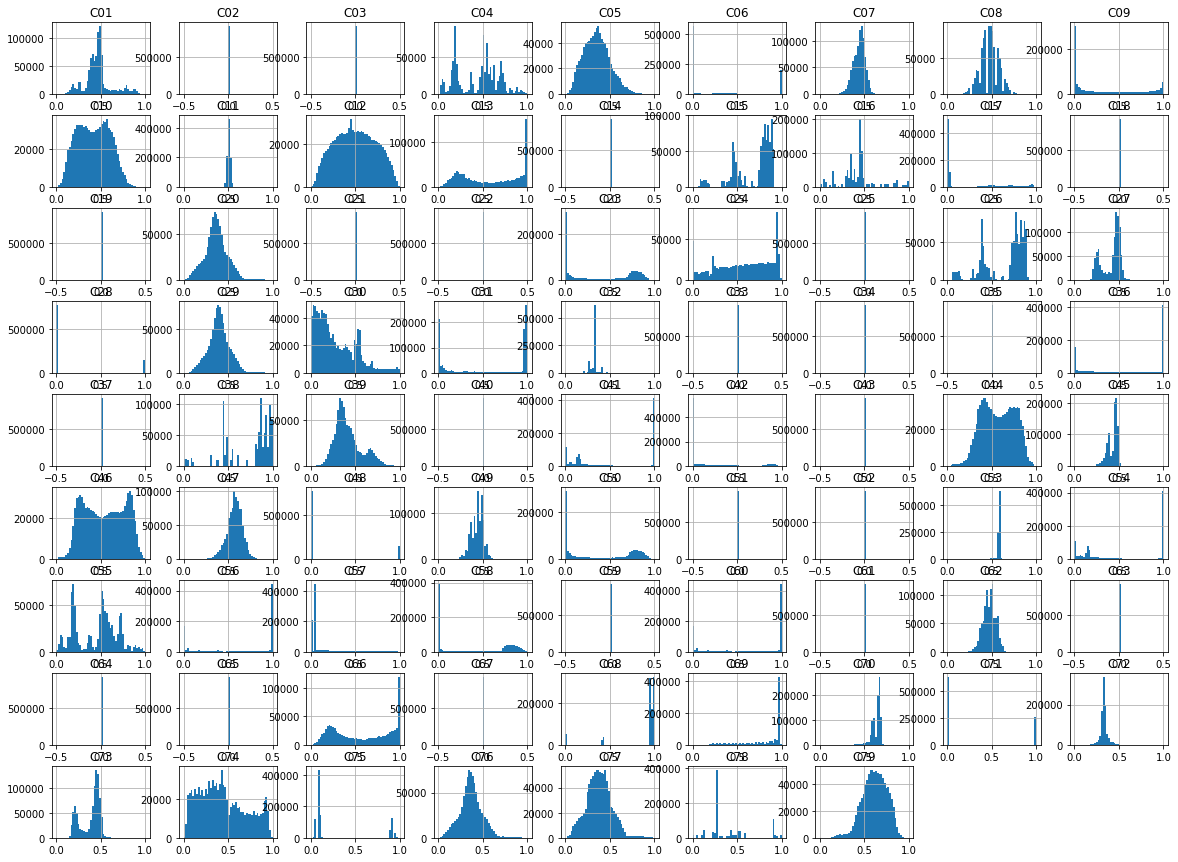

In [74]:
TRAIN_DF.hist(bins=50, figsize=(20, 15))

## Zero value features

In [75]:
TRAIN_DF[['C02','C03','C14','C18','C19','C21','C22','C25','C33','C34','C35','C37','C40',
          'C43','C51','C52','C59','C61','C63','C64','C65','C67']].values.sum(axis=0)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

921603


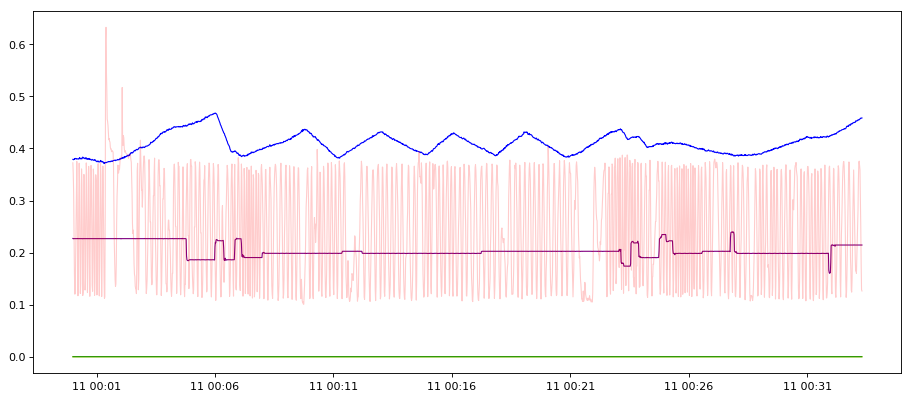

In [193]:
def plot_sp_normal():
    x = TRAIN_DF[['C01', 'C02', 'C03', 'C04', 'C05']].values
    fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    t = pd.to_datetime(TRAIN_DF_RAW['time'])
    print(len(t))
    t = t[:2000]
    ax.plot(t, x[:2000,0], '-', color='blue', animated = True, linewidth=1)
    ax.plot(t, x[:2000,1], '-', color='yellow', animated = True, linewidth=1)
    ax.plot(t, x[:2000,2], '-', color='green', animated = True, linewidth=1)
    ax.plot(t, x[:2000,3], '-', color='purple', animated = True, linewidth=1)
    ax.plot(t, x[:2000,4], '-', color='red', animated = True, linewidth=1, alpha=0.2)
plot_sp_normal()

921603


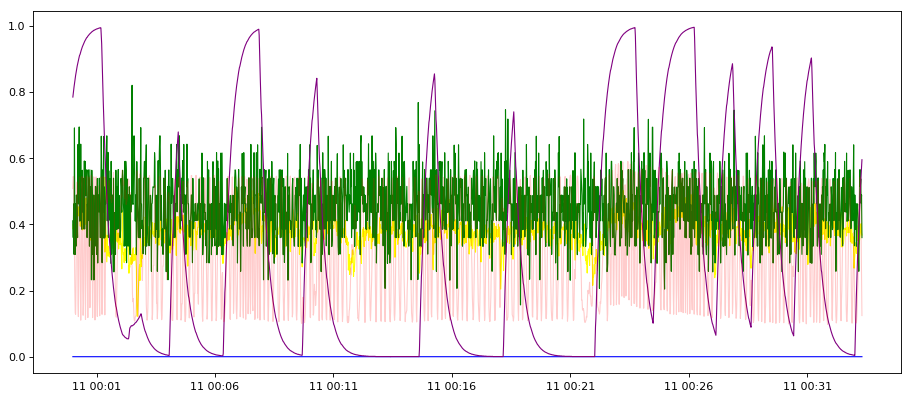

In [192]:
def plot_sp_normal():
    x = TRAIN_DF[['C06', 'C07', 'C08', 'C09', 'C10']].values
    fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    t = pd.to_datetime(TRAIN_DF_RAW['time'])
    print(len(t))
    t = t[:2000]
    ax.plot(t, x[:2000,0], '-', color='blue', animated = True, linewidth=1)
    ax.plot(t, x[:2000,1], '-', color='yellow', animated = True, linewidth=1)
    ax.plot(t, x[:2000,2], '-', color='green', animated = True, linewidth=1)
    ax.plot(t, x[:2000,3], '-', color='purple', animated = True, linewidth=1)
    ax.plot(t, x[:2000,4], '-', color='red', animated = True, linewidth=1, alpha=0.2)
plot_sp_normal()

921603


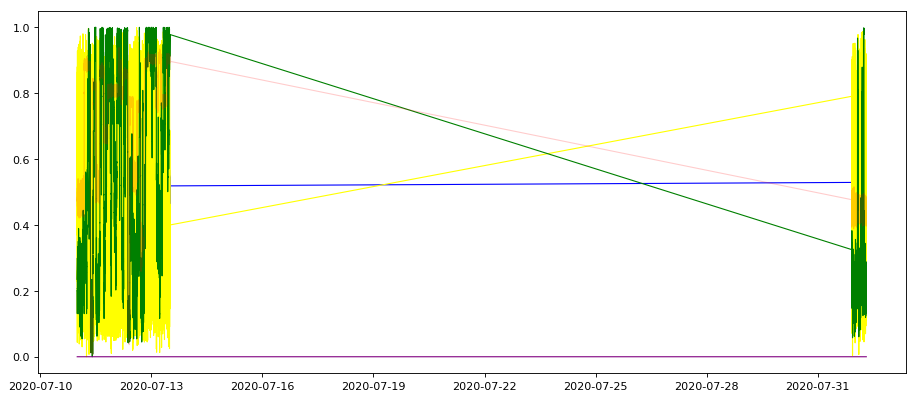

In [181]:
def plot_sp_normal():
    x = TRAIN_DF[['C11', 'C12', 'C13', 'C14', 'C15']].values
    fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    t = pd.to_datetime(TRAIN_DF_RAW['time'])
    print(len(t))
    t = t[:250000]
    ax.plot(t, x[:250000,0], '-', color='blue', animated = True, linewidth=1)
    ax.plot(t, x[:250000,1], '-', color='yellow', animated = True, linewidth=1)
    ax.plot(t, x[:250000,2], '-', color='green', animated = True, linewidth=1)
    ax.plot(t, x[:250000,3], '-', color='purple', animated = True, linewidth=1)
    ax.plot(t, x[:250000,4], '-', color='red', animated = True, linewidth=1, alpha=0.2)
plot_sp_normal()

921603


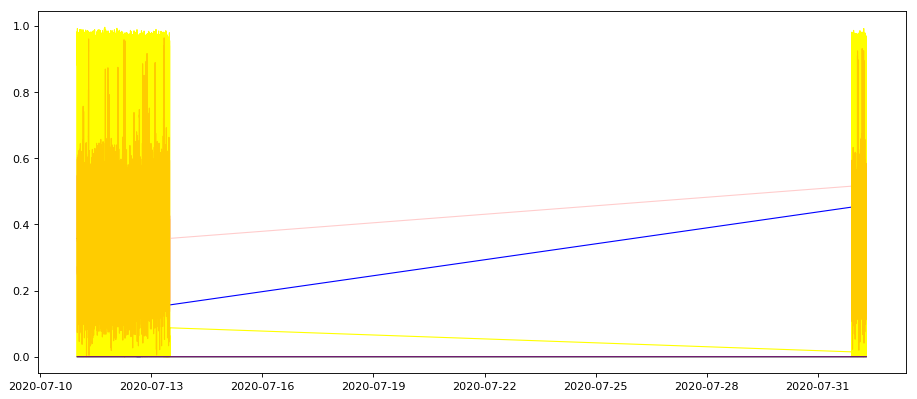

In [182]:
def plot_sp_normal():
    x = TRAIN_DF[['C16', 'C17', 'C18', 'C19', 'C20']].values
    fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    t = pd.to_datetime(TRAIN_DF_RAW['time'])
    print(len(t))
    t = t[:250000]
    ax.plot(t, x[:250000,0], '-', color='blue', animated = True, linewidth=1)
    ax.plot(t, x[:250000,1], '-', color='yellow', animated = True, linewidth=1)
    ax.plot(t, x[:250000,2], '-', color='green', animated = True, linewidth=1)
    ax.plot(t, x[:250000,3], '-', color='purple', animated = True, linewidth=1)
    ax.plot(t, x[:250000,4], '-', color='red', animated = True, linewidth=1, alpha=0.2)
plot_sp_normal()

In [150]:
stl_test = TRAIN_DF[['C01', 'C02', 'C03', 'C04', 'C05']]
t = pd.to_datetime(TRAIN_DF_RAW['time'])
stl_test = pd.concat([t,stl_test['C05']], axis=1)
print(stl_test.info())
stl_test.set_index('time', inplace=True)
stl_test = stl_test.asfreq(pd.infer_freq(stl_test.index),method='pad')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 921603 entries, 0 to 478800
Data columns (total 2 columns):
time    921603 non-null datetime64[ns]
C05     921603 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.1 MB
None


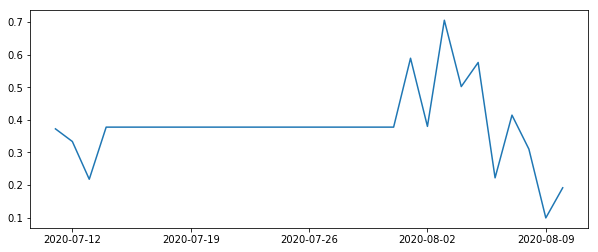

In [151]:
plt.figure(figsize=(10,4))
plt.plot(stl_test)

In [152]:
stl = STL(stl_test)
result = stl.fit()

In [153]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

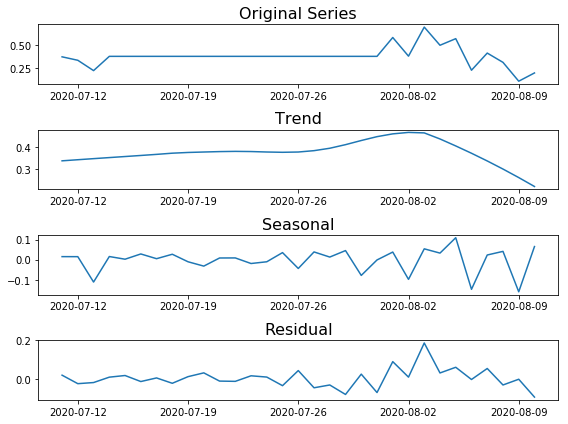

In [154]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(stl_test)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

/Users/jinpark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """


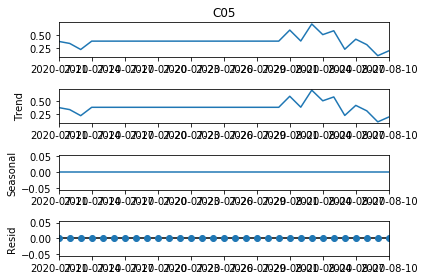

In [160]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = stl_test['C05']
result = seasonal_decompose(series, model='additive', freq=1)
result.plot()
pyplot.show()

# Normalize

In [ ]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90

class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [ ]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

In [ ]:
TRAIN_DF.shape

In [138]:
28*28

784

In [ ]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"]#.cuda()
            guess = model(given)
            answer = batch["answer"]#.cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [ ]:
%%time
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 32)

In [ ]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

In [ ]:
with open("outputs/hai_model_v02.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

### Load the model

In [ ]:
with open("outputs/hai_model_v02.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

In [ ]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

# Validation

In [120]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
5,2020-07-07 15:00:05,403.01621,12.0,10,51.94244,-1.3759,-1.86768,782.47815,28.03078,528,...,0.0,1.34293,10.74636,34.88770,12.26196,383.49969,388.00275,32.59527,6.1763,0
6,2020-07-07 15:00:06,403.06729,12.0,10,51.97296,-1.1795,-1.86768,785.01923,28.02993,504,...,0.0,1.34445,10.72779,34.90295,12.26196,383.13800,388.87079,32.59527,6.1388,0
7,2020-07-07 15:00:07,403.16956,12.0,10,51.97296,-1.0166,-1.86768,788.18091,28.02473,472,...,0.0,1.34979,10.64787,34.88770,12.26196,383.08374,386.61029,32.59527,5.8245,0
8,2020-07-07 15:00:08,403.16956,12.0,10,51.97296,-1.1606,-1.86768,786.43866,28.02899,448,...,0.0,1.35513,10.60738,34.88770,12.26196,383.31885,385.39856,32.59527,5.4822,0
9,2020-07-07 15:00:09,403.42511,12.0,10,51.97296,-1.4129,-1.86005,784.76270,28.03081,432,...,0.0,1.35513,10.52999,34.88770,12.26196,383.21039,385.88684,32.59527,5.4415,0


In [123]:
VALID_COLUMNS_IN_VALID_DATASET = VALIDATION_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALIDATION_DF = normalizeMinMax(VALIDATION_DF_RAW[VALID_COLUMNS_IN_VALID_DATASET])

In [124]:
boundary_check(VALIDATION_DF)

(False, False, False)

In [125]:
VALIDATION_DF[['C02','C03','C14','C18','C19','C21','C22','C25','C33','C34','C35','C37','C40',
          'C43','C51','C52','C59','C61','C63','C64','C65','C67']].values.sum(axis=0)

array([27.94592429,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [132]:
print(VALIDATION_DF_RAW.groupby(['attack'])['C02'].count())

attack
0    42572
1      629
Name: C02, dtype: int64


In [136]:
is_attack = VALIDATION_DF_RAW['attack'] == 1
anom = VALIDATION_DF_RAW[is_attack]
is_not_attack = VALIDATION_DF_RAW['attack'] == 0
clean = VALIDATION_DF_RAW[is_not_attack]

In [ ]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

In [ ]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"]#.cuda()
            answer = batch["answer"]#.cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [ ]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

In [ ]:
CHECK_DIST.shape

In [ ]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [ ]:
THRESHOLD = 0.04
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [ ]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [ ]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

In [ ]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

In [ ]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [ ]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

# Evaluation

In [ ]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

In [ ]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

# Test

In [ ]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

### Normalize

In [ ]:
TEST_DF = normalizeMinMax(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

In [ ]:
boundary_check(TEST_DF)

In [ ]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]

In [ ]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

In [ ]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [ ]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [ ]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

In [ ]:
submission.to_csv('baseline.csv', index=False)